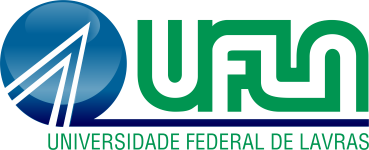

# Parallel Simulated Annealing

Trabalho Final da disciplina **Programação Paralela e Concorrente** (2023/1).


**Professora:** Marluce Rodrigues Pereira

**Alunos:**

- João Gabriel Kondarzewski Zanella - 202020091
- Henrique Curi de Miranda - 202020087
- Victor Gonçalves Lima - 202020775

O trabalho tem como objetivo paralelizar o algorimo de otimização ***Simulated Annealing*** e analizar os resutados obtidos.

## Importações

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from src.funcoes_registro import carregar_populacao, carregar_solucao_inicial, carregar_parametros_populacao, carregar_cpu_info, carregar_experimentacao, carregar_algoritmos
from src.funcoes_plotagem import plotar_itens

## Dispersão dos itens

In [2]:
parametros_populacao = carregar_parametros_populacao("./parametros_iniciais/")

parametros_populacao

{'numero_itens': 10000,
 'valor_minimo': 1,
 'valor_maximo': 5,
 'tipo_valor': 'int',
 'peso_minimo': 10.0,
 'peso_maximo': 1000.0,
 'tipo_peso': 'float'}

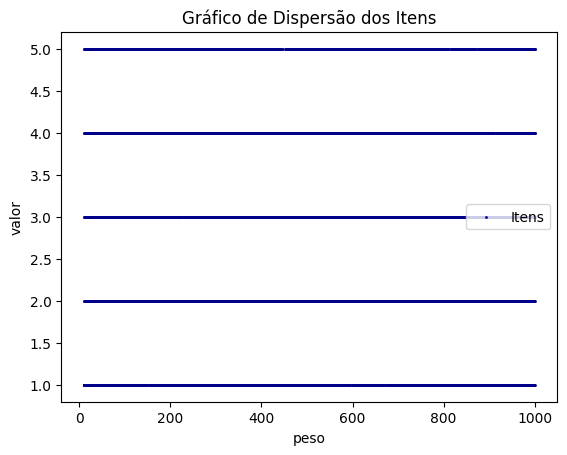

In [3]:
itens = carregar_populacao("./parametros_iniciais/")

plotar_itens(itens)

## Solução aleatória

Total de itens na mochila: 26
Valor total na mochila: 67
Peso total na mochila: 9990.8798892551


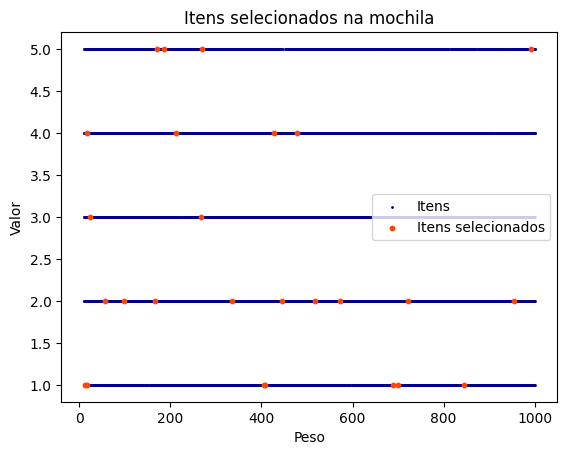

In [4]:
capacidade_das_mochilas = 10000.0 # 10 toneladas
mochila_inicial = carregar_solucao_inicial("./parametros_iniciais/", itens)
plotar_itens(itens, mochila_inicial)

## Funções para prepação dos dados

In [5]:
def carregar_execucoes(parametros_experimentacao, diretorio):
    execucoes = {}
    processes_numbers = parametros_experimentacao["processes_number"]
    numero_execucoes = parametros_experimentacao["numero_execucoes"]
    for i in processes_numbers:
        execucoes[f"psa{i}"] = {"run_times": [],
                                 "final_value": []}
        for j in range(numero_execucoes):
            f = open(f"{diretorio}run-PSA{i}-{j}.json")
            j = json.load(f)
            execucoes[f"psa{i}"]["run_times"].append(j["execution_time"])
            execucoes[f"psa{i}"]["final_value"].append(j["value"][-1])
    return execucoes

## Funções para análises estatísticas

### Média aritmética

In [6]:
def media_aritmetica(populacao): 
    return sum(populacao) / len(populacao)

### Desvio padrão

O desvio padrão é definido como:

$\sigma = \sqrt{\frac{ \sum(x_i - \mu)^2}{N}}$

onde $N$ é o tamanho da população, $x_i$ é cada valor da população e $\mu$ é a média aritmética da população.

In [7]:
def desvio_padrao(populacao):
    media = media_aritmetica(populacao)
    soma_dos_quadrados = sum((x - media) ** 2 for x in populacao)
    return (soma_dos_quadrados / len(populacao)) ** 0.5

### Intervalo de confiança

O intervalo de confiança pode é definido como:

$CI = \bar{x} \pm z_{\frac{\alpha}{2}} \frac{\sigma}{\sqrt{n}}$

onde $\bar{x}$ é a média da amostra, $z_{\frac{\alpha}{2}}$ é o valor crítico para a distribuição normal padrão correspondente a um nível de confiança de $1-\alpha$, $\sigma$ é o desvio padrão da população, e $n$ é o tamanho da amostra.

Para um intervalo de confiança de 95%, será:

$CI = \bar{x} \pm 1.96 \frac{\sigma}{\sqrt{n}}$

In [8]:
def intervalo_confianca(populacao):
    desvio = desvio_padrao(populacao)
    margem_de_erro = 1.96 * desvio / (len(populacao) ** 0.5)
    return margem_de_erro

## Funções para análises de desempenho

### Speedup

O $Speedup$ é definido como:

$S = \frac{T_s}{T_{sp}}$

onde $T_s$ é o tempo de execução sequencial e $T_{sp}$ é o tempo de execução paralelo.

In [9]:
def calcular_speedup(execucoes):
    media_sequencial = media_aritmetica(execucoes["psa1"]["run_times"])
    speedup = []
    for k in execucoes.keys():
        speedup.append(media_sequencial / media_aritmetica(execucoes[k]["run_times"]))
    return speedup

### Eficiência

Conhecendo os valores de $Speedup$ pelos tempos de execução sequencial e paralelo, podemos calcular a eficiência como:

$E = \frac{S}{p}$, onde $p$ é o número de processos em paralelo e $0 \leq E(n, p) \leq 1$

In [10]:
def calcular_eficiencia(execucoes):
    eficiencia = []
    speedup = calcular_speedup(execucoes)
    for i, k in enumerate(execucoes.keys()):
        eficiencia.append(speedup[i] / int(k[3:]))
    return eficiencia

### Métrica de KarpFlat

$e = \frac{\frac{1}{S} - \frac{1}{p}}{1 - \frac{1}{p}}$

In [11]:
def calcular_karpflat(execucoes):
    karpflat = []
    speedup = calcular_speedup(execucoes)
    for i, k in enumerate(execucoes.keys()):
        if int(k[3:]) == 1:
            karpflat.append(None)
            continue
        karpflat.append((1 / speedup[i] - 1 / int(k[3:])) / (1 - 1 / int(k[3:])))
    return karpflat

## Funções para exibição dos resultados

In [12]:
def display_execucoes(execucoes, parametros_algoritmo):
    for i in range(len(execucoes)):
        print(f"Tamanho da população explorada: {parametros_algoritmo[i]['numero_vizinhos_explorar']}")
        display(pd.concat([pd.DataFrame(execucoes[i][k]) for k in execucoes[i].keys()],
                          axis=1, keys=execucoes[i].keys()))
        
        
def plotar_valores_finais(execucoes, parametros_algoritmo):
    fig, axs = plt.subplots(1, len(execucoes), figsize=(15, 5))
    for i in range(len(execucoes)):
        for key in execucoes[i]:
            axs[i].plot(execucoes[i][key]['final_value'], label=key)
        axs[i].set_xlabel('Execução')
        axs[i].set_ylabel('Valor final da mochila')
        axs[i].set_ylim(0)
        axs[i].set_xlim(0, len(execucoes[i][next(iter(execucoes[i]))]["final_value"]) - 1)
        axs[i].legend()
        axs[i].set_title(f"Tamanho da população explorada: {parametros_algoritmo[i]['numero_vizinhos_explorar']}")
    plt.show()
    
    
def calcular_media_valor_com_erro(execucoes):
    media = {}
    for k in execucoes.keys():
        ma = media_aritmetica(execucoes[k]["final_value"])
        me = intervalo_confianca(execucoes[k]["final_value"])
        media[k] = (ma, me)
    return media


def display_media_valores(execucoes, parametros_algoritmo):
    dfs = []
    for i in range(len(execucoes)):
        media = calcular_media_valor_com_erro(execucoes[i])
        df = {}
        for k in media.keys():
            df[k] = {parametros_algoritmo[i]["numero_vizinhos_explorar"]: str(media[k][0]) + " ± " + str(media[k][1])}
        df = pd.DataFrame(df)
        dfs.append(df)
    dfs = pd.concat(dfs)
    print("Média de valores")
    display(dfs)
    
    
def plotar_media_valores(execucoes, parametros_algoritmo):
    fig, axs = plt.subplots(1, len(execucoes), figsize=(15, 5))
    for i in range(len(execucoes)):
        threads = [k[3:] for k in execucoes[i].keys()]
        media = calcular_media_valor_com_erro(execucoes[i])
        x, y = [], []
        for k in media.keys():
            x.append(media[k][0])
            y.append(media[k][1])
        axs[i].plot(threads, x)
        axs[i].errorbar(threads, x, yerr=y, fmt='none', capsize=10)
        axs[i].fill_between(threads, [i-k for i, k in zip(x, y)], [i+k for i, k in zip(x, y)], color='b', alpha=.25)
        axs[i].set_xlabel('Número de threads')
        axs[i].set_ylabel('Valor final da mochila')
        axs[i].set_ylim(0)
        axs[i].set_xlim(0, threads[-1])
        axs[i].set_title(f"Valor final da mochila\n(Intervalo de Confiança de 95%)\nTamanho da população explorada: {parametros_algoritmo[i]['numero_vizinhos_explorar']}")
    plt.show()


def plotar_tempos_execucao(execucoes, parametros_algoritmo):
    fig, axs = plt.subplots(1, len(execucoes), figsize=(15, 5))
    for i in range(len(execucoes)):
        for key in execucoes[i]:
            axs[i].plot(execucoes[i][key]['run_times'], label=key)
        axs[i].set_xlabel('Execução')
        axs[i].set_ylabel('Tempo de Execução (segundos)')
        axs[i].set_ylim(0)
        axs[i].set_xlim(0, len(execucoes[i][next(iter(execucoes[i]))]["run_times"]) - 1)
        axs[i].legend()
        axs[i].set_title(f"Tamanho da população explorada: {parametros_algoritmo[i]['numero_vizinhos_explorar']}")
    plt.show()


def calcular_media_tempo_com_erro(execucoes):
    media = {}
    for k in execucoes.keys():
        ma = media_aritmetica(execucoes[k]["run_times"])
        me = intervalo_confianca(execucoes[k]["run_times"])
        media[k] = (ma, me)
    return media


def display_media_tempos(execucoes, parametros_algoritmo):
    dfs = []
    for i in range(len(execucoes)):
        media = calcular_media_tempo_com_erro(execucoes[i])
        df = {}
        for k in media.keys():
            df[k] = {parametros_algoritmo[i]["numero_vizinhos_explorar"]: str(media[k][0]) + " ± " + str(media[k][1])}
        df = pd.DataFrame(df)
        dfs.append(df)
    dfs = pd.concat(dfs)
    print("Média de tempos")
    display(dfs)


def plotar_media_tempos(execucoes, parametros_algoritmo):
    fig, axs = plt.subplots(1, len(execucoes), figsize=(15, 5))
    for i in range(len(execucoes)):
        threads = [k[3:] for k in execucoes[i].keys()]
        media = calcular_media_tempo_com_erro(execucoes[i])
        x, y = [], []
        for k in media.keys():
            x.append(media[k][0])
            y.append(media[k][1])
        axs[i].plot(threads, x)
        axs[i].errorbar(threads, x, yerr=y, fmt='none', capsize=10)
        axs[i].fill_between(threads, [i-k for i, k in zip(x, y)], [i+k for i, k in zip(x, y)], color='b', alpha=.25)
        axs[i].set_xlabel('Número de threads')
        axs[i].set_ylabel('Tempo médio de execução (segundos)')
        axs[i].set_ylim(0)
        axs[i].set_xlim(0, threads[-1])
        axs[i].set_title(f"Tempo de Execução\n(Intervalo de Confiança de 95%)\nTamanho da população explorada: {parametros_algoritmo[i]['numero_vizinhos_explorar']}")
    plt.show()


def plotar_speedup(execucoes, parametros_algoritmo):
    fig, ax = plt.subplots()
    for i in range(len(execucoes)):
        threads = [k[3:] for k in execucoes[i].keys()]
        speedup = calcular_speedup(execucoes[i])
        ax.plot(threads, speedup, label=f"População explorada: {parametros_algoritmo[i]['numero_vizinhos_explorar']}")
    ax.set_xlabel('Número de threads')
    ax.set_ylabel('Speedup')
    ax.set_ylim(0)
    ax.legend()
    plt.title("Speedup")
    plt.show()


def plotar_eficiencia(execucoes, parametros_algoritmo):
    fig, ax = plt.subplots()
    for i in range(len(execucoes)):
        threads = [k[3:] for k in execucoes[i].keys()]
        eficiencia = calcular_eficiencia(execucoes[i])
        ax.plot(threads, eficiencia, label=f"População explorada: {parametros_algoritmo[i]['numero_vizinhos_explorar']}")
    ax.set_xlabel('Número de threads')
    ax.set_ylabel('Eficiência')
    ax.set_ylim(0)
    ax.legend()
    plt.title("Eficiência")
    plt.show()
    
    
def plotar_karpflat(execucoes, parametros_algoritmo):
    fig, ax = plt.subplots()
    for i in range(len(execucoes)):
        threads = [k[3:] for k in execucoes[i].keys()]
        karpflat = calcular_karpflat(execucoes[i])
        ax.plot(threads, karpflat, label=f"População explorada: {parametros_algoritmo[i]['numero_vizinhos_explorar']}")
    ax.set_xlabel('Número de threads')
    ax.set_ylabel('Métrica de KarpFlat')
    ax.set_ylim(0)
    ax.legend()
    plt.title("Métrica de KarpFlat")
    plt.show()


def exibir_resultados_execucoes(datas):
    execucoes, parametros_experimentacao, parametros_algoritmo = [], [], []
    for data in datas:
        parametros_experimentacao.append(carregar_experimentacao(data))
        parametros_algoritmo.append(carregar_algoritmos(data))
        execucoes.append(carregar_execucoes(parametros_experimentacao[-1], data))
    cpu_info = carregar_cpu_info(datas[0])
    print("==========" * 5, "INFORMAÇÕES DO HARDWARE", "==========" * 5)
    print("Versão do Python:", cpu_info["python_version"])
    print("Hardware da CPU:", cpu_info["brand_raw"])
    print("Número de threads disponíveis:", cpu_info["count"])
    print("==========" * 5, "INFORMAÇÕES DO EXPERIMENTO", "==========" * 5)
    print("Número de threads utilizadas:", parametros_experimentacao[0]["processes_number"])
    print("Número de execuções por thread:", parametros_experimentacao[0]["numero_execucoes"])
    print("==========" * 5, "PARÂMETROS DO ALGORITMO", "==========" * 5)
    print("Temperatura inicial:", parametros_algoritmo[0]["temperatura_inicial"])
    print("Temperatura final:", parametros_algoritmo[0]["temperatura_final"])
    print("Taxa de resfriamento:", parametros_algoritmo[0]["taxa_resfriamento"])
    print("==========" * 5, "INFORMAÇÕES DA EXECUÇÃO", "==========" * 5)
    display_execucoes(execucoes, parametros_algoritmo)
    print("==========" * 5, "ANÁLISE DOS VALORES", "==========" * 5)
    plotar_valores_finais(execucoes, parametros_algoritmo)
    display_media_valores(execucoes, parametros_algoritmo)
    plotar_media_valores(execucoes, parametros_algoritmo)
    print("==========" * 5, "ANÁLISE DE DESEMPENHO", "==========" * 5)
    plotar_tempos_execucao(execucoes, parametros_algoritmo)
    display_media_tempos(execucoes, parametros_algoritmo)
    plotar_media_tempos(execucoes, parametros_algoritmo)
    plotar_speedup(execucoes, parametros_algoritmo)
    plotar_eficiencia(execucoes, parametros_algoritmo)
    plotar_karpflat(execucoes, parametros_algoritmo)

## Análises de Desempenho

### Análise 1

================================================== INFORMAÇÕES DO HARDWARE ==================================================
Versão do Python: 3.10.6.final.0 (64 bit)
Hardware da CPU: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
Número de threads disponíveis: 8
================================================== INFORMAÇÕES DO EXPERIMENTO ==================================================
Número de threads utilizadas: [1, 2, 4, 8, 16]
Número de execuções por thread: 10
================================================== PARÂMETROS DO ALGORITMO ==================================================
Temperatura inicial: 1
Temperatura final: 0.1
Taxa de resfriamento: 0.01
================================================== INFORMAÇÕES DA EXECUÇÃO ==================================================
Tamanho da população explorada: 100


psa1                  psa2                  psa4                  psa8  \
  run_times final_value run_times final_value run_times final_value run_times   
0  4.044174         706  4.123683         699  4.663251         645  6.321043   
1  4.160810         702  4.089340         678  4.777537         695  6.419170   
2  4.328833         705  4.099600         684  4.687732         665  6.270398   
3  4.266247         711  4.148254         720  4.732279         690  6.248035   
4  4.267458         698  4.125139         725  4.698247         679  6.330266   
5  4.226179         660  4.029595         663  4.849244         719  6.276807   
6  4.275882         702  4.166130         695  4.710735         691  6.283009   
7  4.228222         698  4.057688         713  4.841761         701  6.205854   
8  4.377928         719  4.427462         727  4.677266         675  6.387965   
9  4.254043         692  4.218026         693  4.739103         670  6.219311   

                  psa16              
  final_value run_times final_value  
0         686  9.419147         687  
1         688  9.383012         704  
2         718  9.387505         716  
3         719  9.364698         685  
4         677  9.274371         701  
5         738  9.517527         716  
6         696  9.517398         738  
7         682  9.303747         692  
8         668  9.397130         671  
9         692  9.269533         666

Tamanho da população explorada: 1000


psa1                   psa2                   psa4              \
   run_times final_value  run_times final_value  run_times final_value   
0  12.493814         804  10.673468         811  10.088367         814   
1  12.936853         830  10.429383         780  10.239532         818   
2  13.443513         809  10.878269         791   9.896110         817   
3  13.133958         821  10.946875         807  10.137882         834   
4  12.745322         807  10.914615         813  10.576617         831   
5  12.459068         780  10.795789         841  11.183124         808   
6  13.267338         784  10.316021         800  10.867780         807   
7  13.194921         813  10.870808         789  10.695814         789   
8  13.006050         815  10.537940         815  10.782006         797   
9  12.794346         816  10.681816         826  10.921947         799   

        psa8                  psa16              
   run_times final_value  run_times final_value  
0  11.491532         822  14.217463         827  
1  11.393401         811  14.163681         811  
2  11.248737         822  14.177085         826  
3  12.145509         861  14.430472         799  
4  11.319938         770  14.403483         805  
5  11.469903         816  14.376079         809  
6  11.036633         795  14.181836         819  
7  11.375494         832  14.302223         814  
8  11.509297         799  14.141219         829  
9  11.336603         796  14.808195         826

Tamanho da população explorada: 10000


psa1                   psa2                   psa4              \
   run_times final_value  run_times final_value  run_times final_value   
0  89.842020         849  62.531554         813  52.374615         835   
1  87.799839         819  61.899371         826  56.436920         830   
2  88.348284         814  63.258492         823  57.035374         805   
3  93.778350         851  63.368140         836  55.443668         807   
4  88.749961         829  63.748317         841  56.442944         819   
5  88.568960         838  63.901951         833  57.440311         829   
6  91.663724         819  61.211401         803  55.941169         790   
7  91.780770         824  61.079640         827  54.329635         792   
8  88.999232         830  64.612360         831  58.190017         839   
9  90.678249         838  62.885899         834  57.597467         805   

        psa8                  psa16              
   run_times final_value  run_times final_value  
0  55.243442         825  58.292257         807  
1  55.277216         814  59.806901         831  
2  52.824226         809  60.025853         833  
3  54.655568         826  58.958426         837  
4  55.788429         826  62.685494         841  
5  57.283972         838  60.551329         853  
6  56.482282         826  58.316003         796  
7  55.556995         837  59.806237         822  
8  55.808549         829  60.405610         838  
9  56.394614         812  60.672826         823

================================================== ANÁLISE DOS VALORES ==================================================


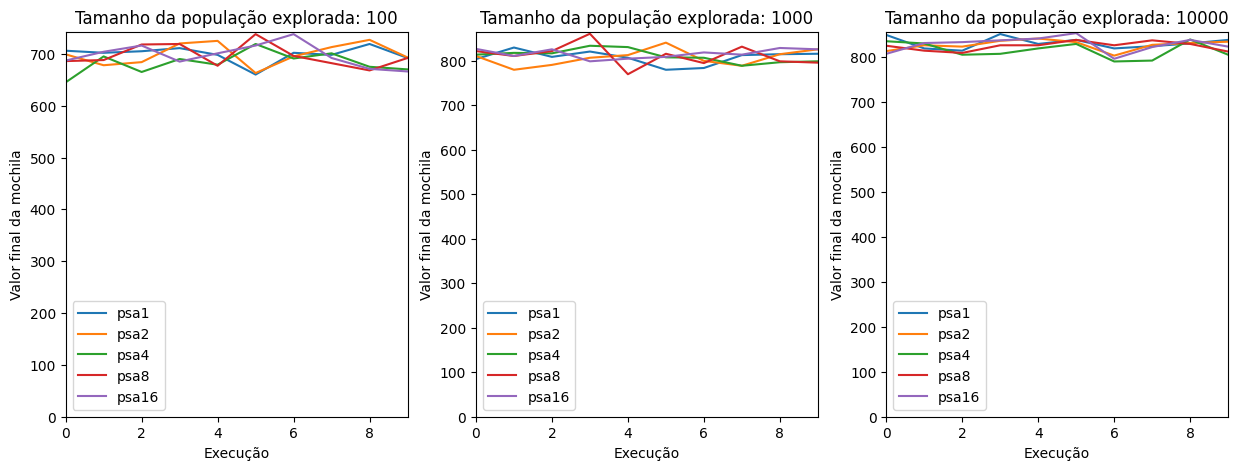

Média de valores


,psa1,psa2,psa4,psa8,psa16
100,699.3 ± 9.230954966849312,699.7 ± 12.559456102873245,683.0 ± 12.230776917268992,696.4 ± 12.847198231521142,697.6 ± 12.957364176405632
1000,807.9 ± 9.128004294477517,807.3 ± 10.717634141917703,811.4 ± 8.476631783910397,812.4 ± 14.528347132416679,816.5 ± 6.149841623976994
10000,831.1 ± 7.470917373388625,826.7 ± 6.693048453432859,815.1 ± 10.428415718602706,824.2 ± 5.78648300783818,828.1 ± 9.868166921976949


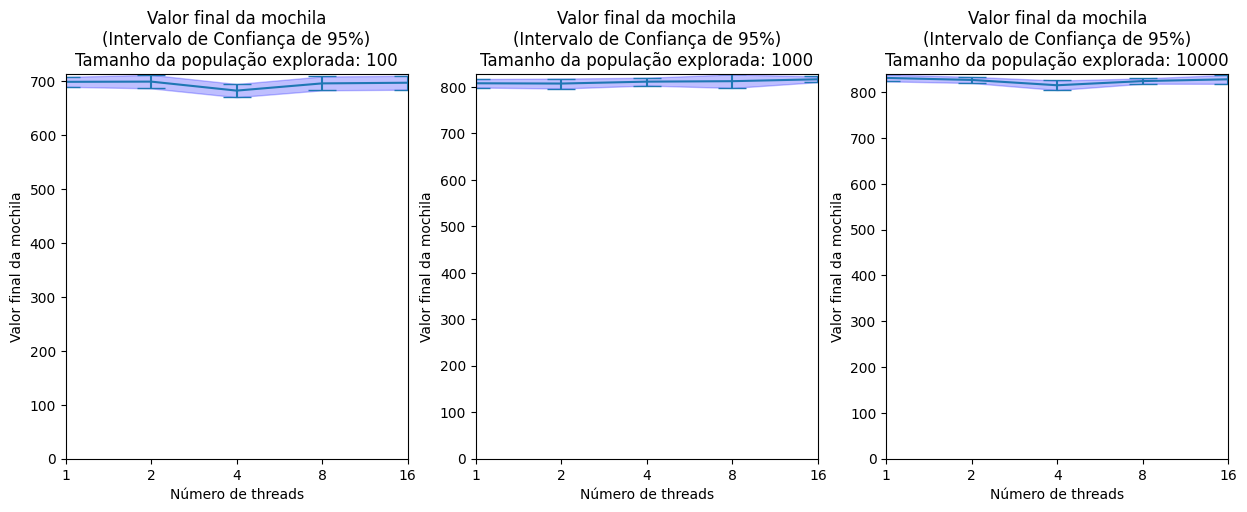

================================================== ANÁLISE DE DESEMPENHO ==================================================


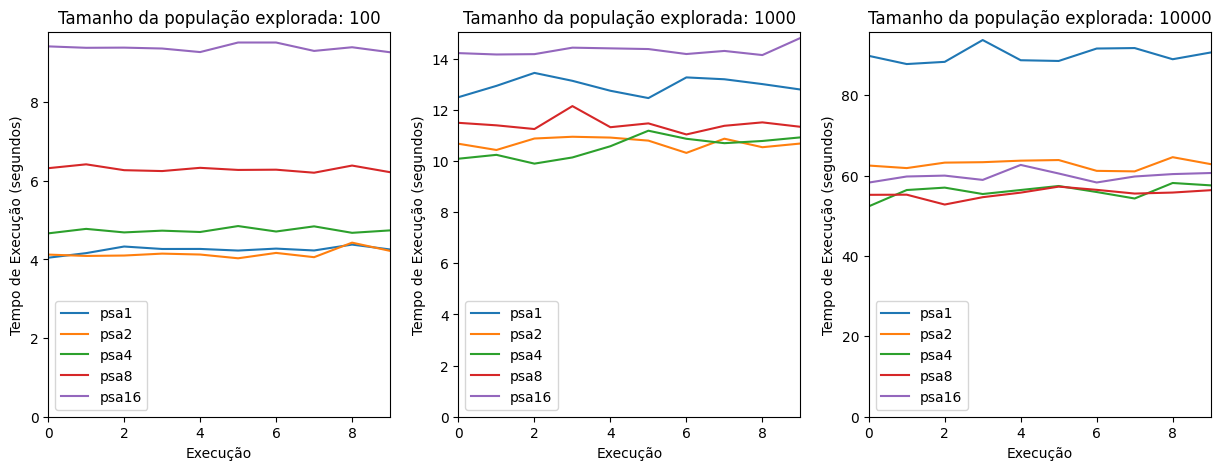

Média de tempos


,psa1,psa2,psa4,psa8,psa16
100,4.242977285385132 ± 0.05357039994189234,4.148491907119751 ± 0.06571192337869725,4.737715578079223 ± 0.0386395088488609,6.296185708045959 ± 0.0406103650376508,9.383406972885131 ± 0.051476102417997306
1000,12.947518277168275 ± 0.191697398314343,10.704498434066773 ± 0.12776229422247795,10.538917851448058 ± 0.24959445649152237,11.432704877853393 ± 0.16818210594038938,14.320173454284667 ± 0.11880165683436196
10000,90.02093884944915 ± 1.123825908680466,62.849712419509885 ± 0.686850497548875,56.12321183681488 ± 1.0179999089610055,55.53152923583984 ± 0.7096108466110056,59.952093505859374 ± 0.7596792539136753


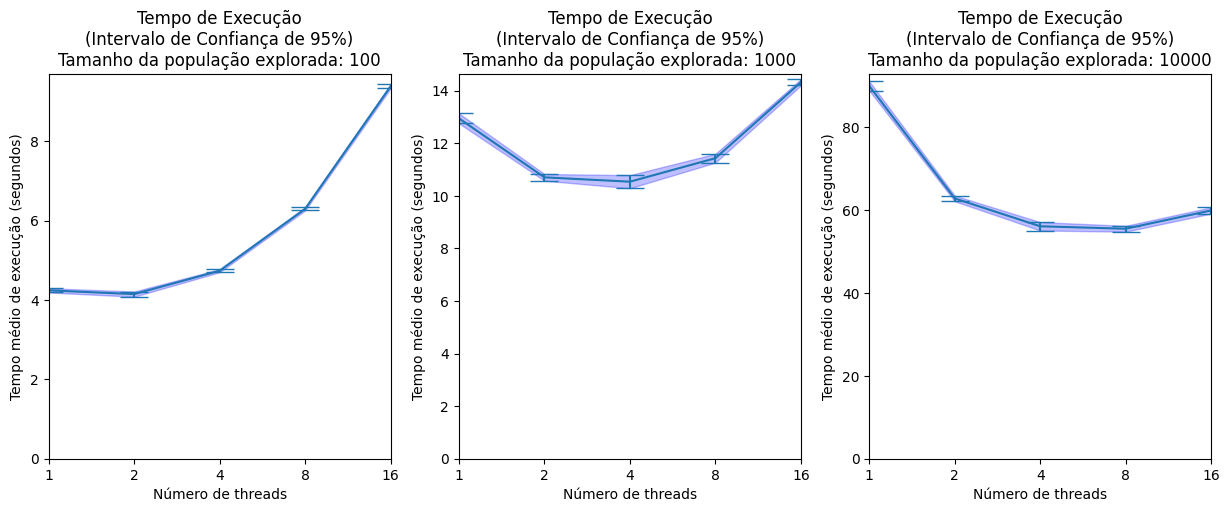

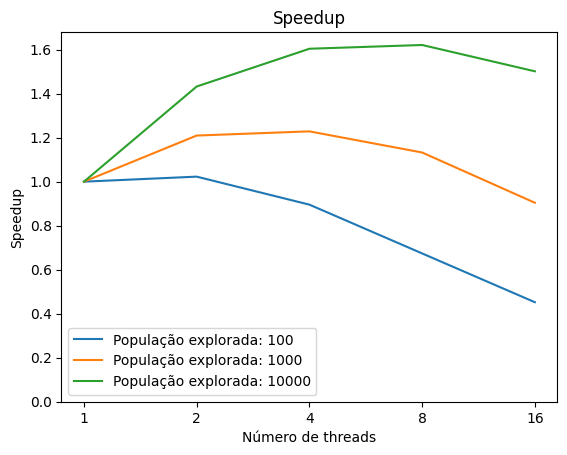

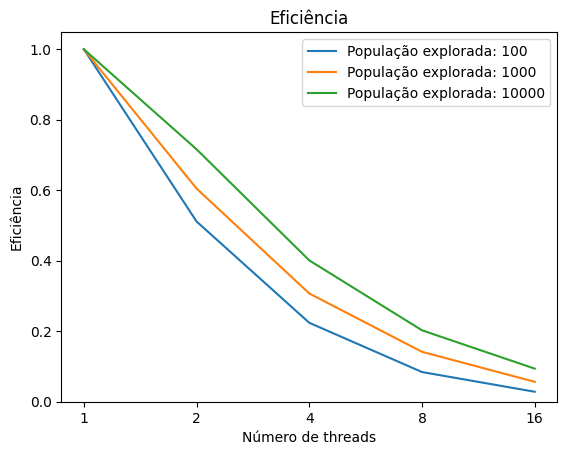

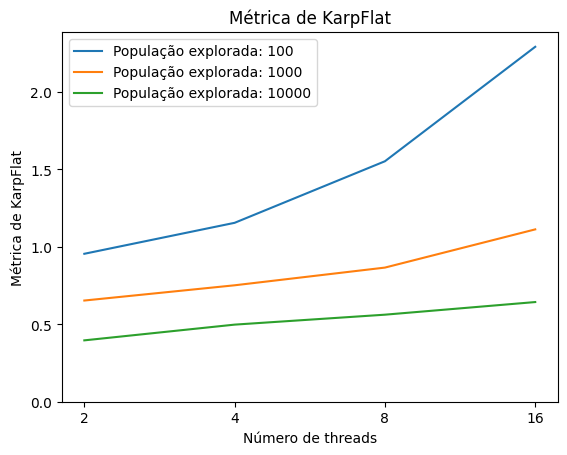

In [13]:
DIRETORIO_DATA_100 = "./data/notebook_i5_100/"
DIRETORIO_DATA_1000 = "./data/notebook_i5_1000/"
DIRETORIO_DATA_10000 = "./data/notebook_i5_10000/"

DATAS = [DIRETORIO_DATA_100, DIRETORIO_DATA_1000, DIRETORIO_DATA_10000]

exibir_resultados_execucoes(DATAS)

### Análise 2

================================================== INFORMAÇÕES DO HARDWARE ==================================================
Versão do Python: 3.11.4.final.0 (64 bit)
Hardware da CPU: AMD Ryzen 7 5700X 8-Core Processor
Número de threads disponíveis: 16
================================================== INFORMAÇÕES DO EXPERIMENTO ==================================================
Número de threads utilizadas: [1, 2, 4, 8, 16]
Número de execuções por thread: 10
================================================== PARÂMETROS DO ALGORITMO ==================================================
Temperatura inicial: 1
Temperatura final: 0.1
Taxa de resfriamento: 0.01
================================================== INFORMAÇÕES DA EXECUÇÃO ==================================================
Tamanho da população explorada: 100


psa1                  psa2                  psa4                  psa8  \
  run_times final_value run_times final_value run_times final_value run_times   
0  3.377119         674  2.916713         698  2.815569         707  3.720597   
1  3.636874         730  2.943799         681  2.828198         698  3.486356   
2  3.213272         708  2.981807         675  2.909361         712  3.481564   
3  3.499331         674  2.988331         701  2.808823         713  3.470438   
4  3.491576         699  3.011410         688  2.956923         679  3.400033   
5  3.647639         694  2.960358         696  2.855173         714  3.453624   
6  3.568515         717  3.005594         703  2.794527         680  3.479386   
7  3.890748         674  2.898794         701  2.854408         697  3.371237   
8  3.816052         735  2.898004         701  2.796229         693  3.393283   
9  3.579224         683  2.958816         675  2.984295         720  3.348856   

                  psa16              
  final_value run_times final_value  
0         720  4.984910         713  
1         685  4.817562         699  
2         706  4.944695         708  
3         720  4.935077         690  
4         687  5.054036         684  
5         660  5.061325         675  
6         754  4.865820         670  
7         707  5.019924         682  
8         699  4.794214         644  
9         720  4.995577         739

Tamanho da população explorada: 1000


psa1                   psa2                  psa4              \
   run_times final_value  run_times final_value run_times final_value   
0  18.640604         832  13.628633         804  8.900467         827   
1  17.383549         810  13.422289         813  8.874274         817   
2  17.737154         824  13.287993         797  8.984806         782   
3  18.183904         817  13.328565         816  8.419574         797   
4  17.727541         788  12.867227         816  8.800434         811   
5  16.798083         765  13.295212         813  8.789181         831   
6  17.821372         825  12.686439         793  8.770530         820   
7  18.409101         813  12.705658         814  9.095911         820   
8  18.149312         819  12.401629         775  8.618222         821   
9  17.556416         788  13.230063         818  8.548685         806   

       psa8                 psa16              
  run_times final_value run_times final_value  
0  8.262481         808  9.106219         821  
1  8.081675         800  9.109487         797  
2  8.619782         819  9.112080         803  
3  8.918737         806  9.205979         822  
4  8.148837         823  9.011142         810  
5  8.035530         798  9.407464         836  
6  8.519442         842  9.232386         836  
7  8.265495         797  8.626722         791  
8  8.091159         817  9.582042         843  
9  8.355323         795  9.375628         813

Tamanho da população explorada: 10000


psa1                   psa2                   psa4              \
    run_times final_value  run_times final_value  run_times final_value   
0  128.695035         835  92.937787         817  61.956626         805   
1  130.633848         819  93.018335         819  59.115875         809   
2  140.074393         830  88.140422         814  66.259886         825   
3  131.801532         843  93.595978         855  66.475625         848   
4  131.526087         832  88.548665         814  62.393033         813   
5  132.660532         825  87.630016         810  61.059376         805   
6  137.451535         830  82.854427         805  62.280399         823   
7  137.494935         834  88.998339         820  65.243204         827   
8  134.725586         847  93.943719         836  67.958490         841   
9  127.901269         810  86.716671         809  63.271286         832   

        psa8                  psa16              
   run_times final_value  run_times final_value  
0  54.708189         834  48.193346         823  
1  58.664449         823  49.453996         864  
2  58.207021         850  50.889464         823  
3  58.917671         841  47.179428         838  
4  54.604862         838  47.625782         824  
5  55.719451         846  46.158837         823  
6  55.646602         823  51.126899         834  
7  56.006588         823  45.272464         842  
8  53.381320         810  51.154264         834  
9  56.912380         840  46.942984         815

================================================== ANÁLISE DOS VALORES ==================================================


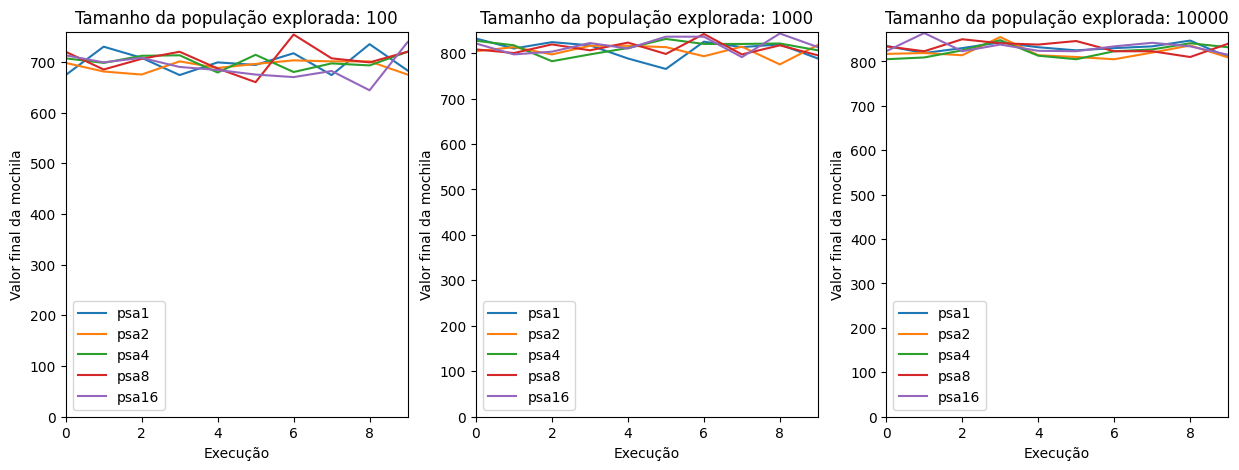

Média de valores


,psa1,psa2,psa4,psa8,psa16
100,698.8 ± 13.604150895958188,691.9 ± 6.591255904605736,701.3 ± 8.416825149663023,705.8 ± 15.003412731775395,690.4 ± 15.401160683532913
1000,808.1 ± 12.397522913872754,805.9 ± 8.130811423222159,813.2 ± 8.694096939878227,810.5 ± 8.718145215583414,817.2 ± 10.326056827269543
10000,830.5 ± 6.34053183889175,819.9 ± 8.78486780777036,822.8 ± 8.751350615762115,832.8 ± 7.400395232688589,832.0 ± 8.232


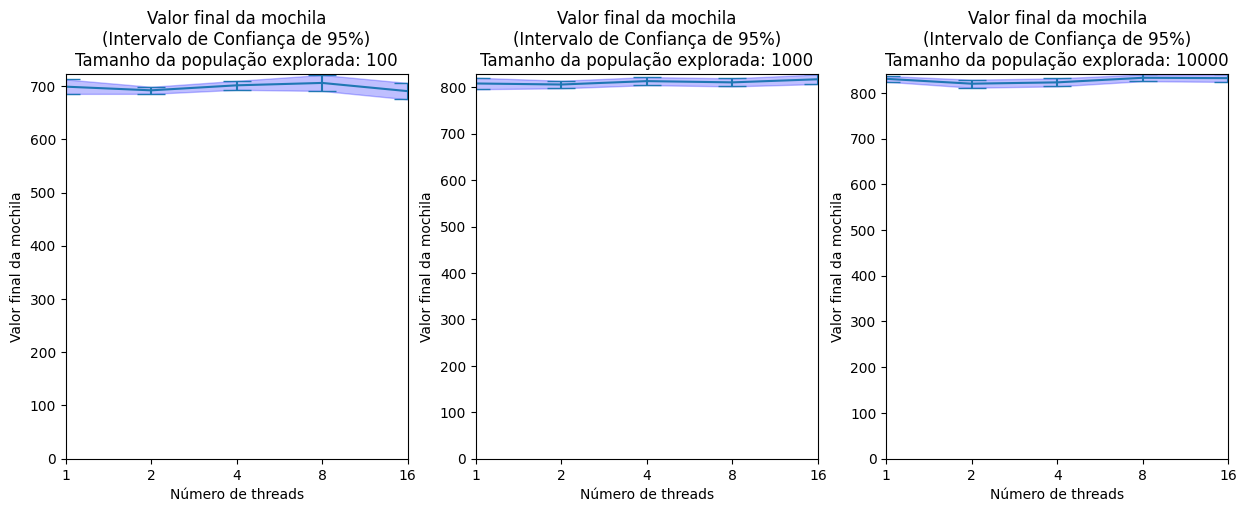

================================================== ANÁLISE DE DESEMPENHO ==================================================


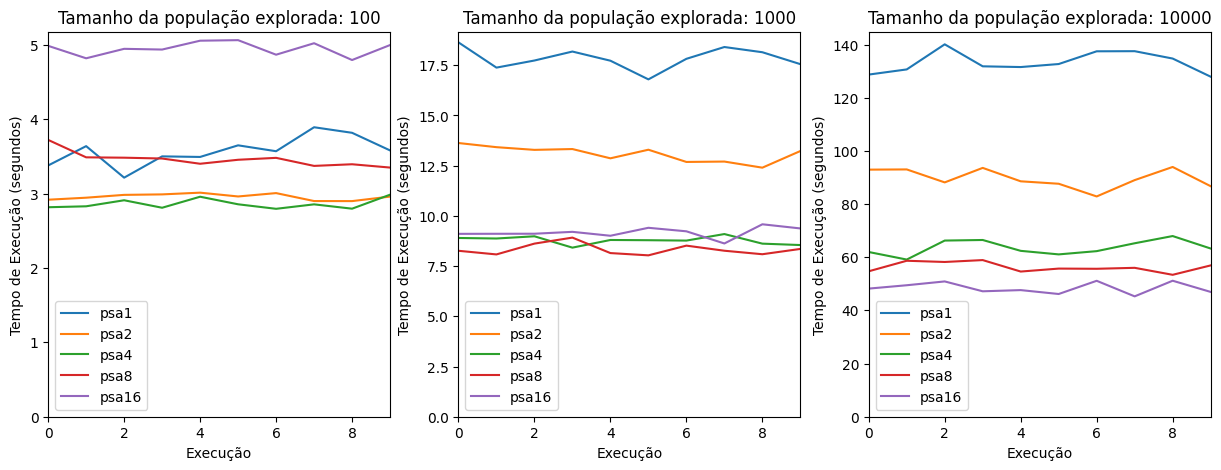

Média de tempos


,psa1,psa2,psa4,psa8,psa16
100,3.572035050392151 ± 0.11588376538445526,2.95636248588562 ± 0.024476434750958842,2.8603506803512575 ± 0.039827644974846615,3.46053729057312 ± 0.06131767364740173,4.947313809394837 ± 0.055601944175919946
1000,17.840703511238097 ± 0.31462184662697446,13.085370922088623 ± 0.23126626460299643,8.780208516120911 ± 0.12007640416664432,8.329846096038818 ± 0.16562609789760838,9.176914882659911 ± 0.15240557265736557
10000,133.29647512435912 ± 2.3684291783890123,89.63843584060669 ± 2.13758321154685,63.6013801574707 ± 1.6352760083465994,56.27685332298279 ± 1.0952403701288065,48.39974634647369 ± 1.260957875536388


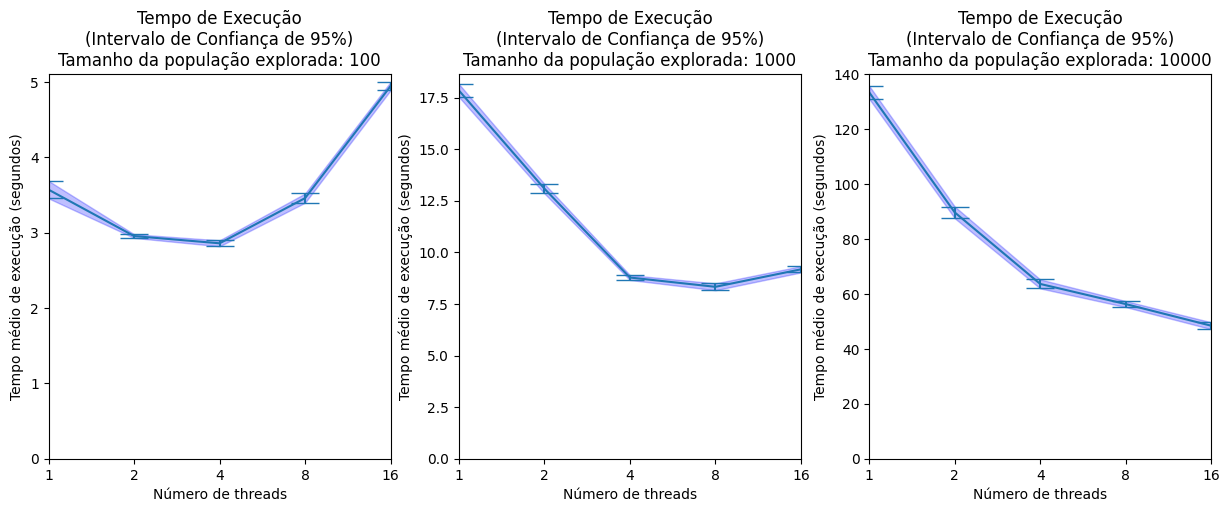

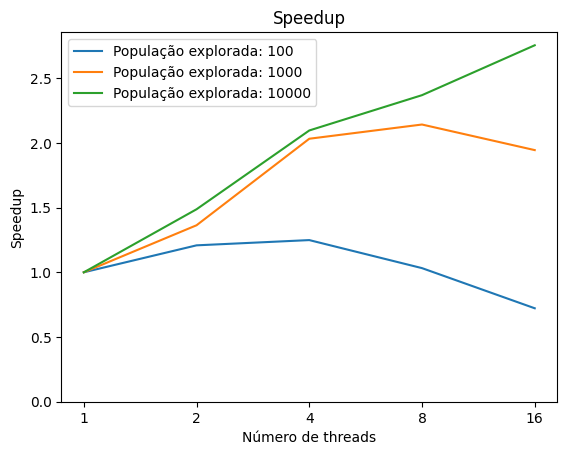

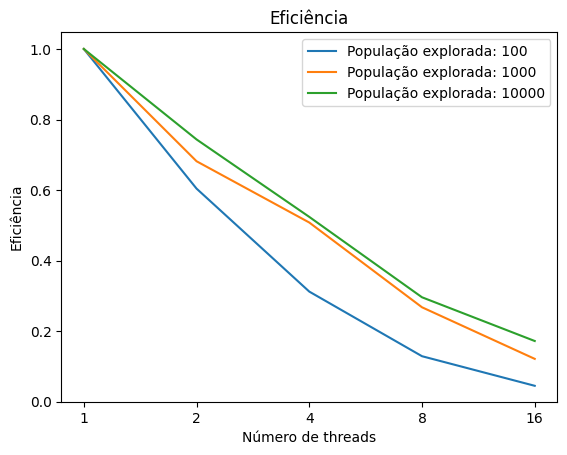

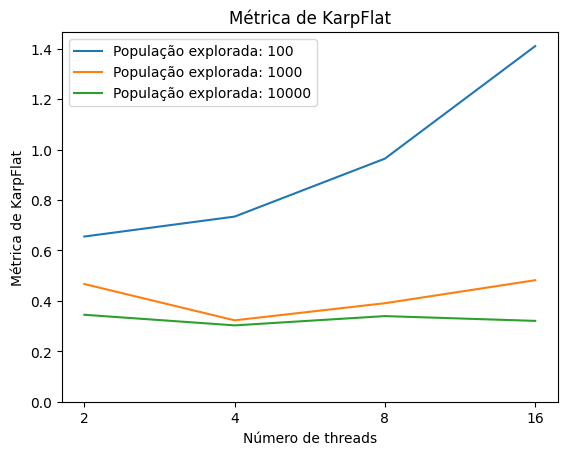

In [14]:
DIRETORIO_DATA_100 = "./data/ryzen_5700x_100/"
DIRETORIO_DATA_1000 = "./data/ryzen_5700x_1000/"
DIRETORIO_DATA_10000 = "./data/ryzen_5700x_10000/"

DATAS = [DIRETORIO_DATA_100, DIRETORIO_DATA_1000, DIRETORIO_DATA_10000]

exibir_resultados_execucoes(DATAS)